In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# XOR Distillation and Verification Example

In this notebook, we demonstrate network distillation and verification in a loop. First, we train an overparametrized network on the xor problem, graphing the decision boundary. Next we distill this network using Hinton distillation. Finally, we verify both networks using nnenum to check that the decision is stable within a certain region.

## The dataset
Here is the dataset we will train with. It includes 1000 uniformly distributed samples of the xor function within the region (-1,1) of the $\mathbb{R}^2$ plane.

In [2]:
def dataset_xor_uniform(n=1000):
    i1 = np.random.random(n)*2-1
    i2 = np.random.random(n)*2-1
    target = np.logical_xor(i1>0, i2>0).astype(int)
    return np.array([i1, i2]), np.array([target])

inputs, outputs = dataset_xor_uniform()

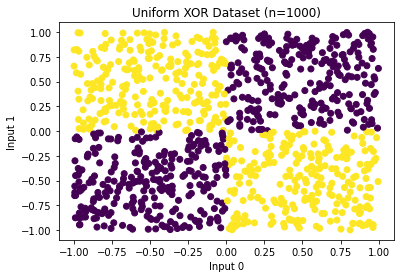

In [6]:
plt.scatter(inputs[0], inputs[1], c=outputs)
plt.title("Uniform XOR Dataset (n=1000)")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

## Train large network

Now, train a fully connected neural network on this dataset with ~5,000 free parameters for 100 epochs.

In [4]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=50
num_hidden_layers=3

layers = [ tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu, input_shape=(num_inputs,))]
for i in range(num_hidden_layers-1):
    layers.append( tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu))
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

model = tf.keras.Sequential(layers)

model.compile(
# loss='binary_crossentropy', # binary classification
# loss='categorical_crossentropy', # categorical classification (one hot)
loss='mean_squared_error',  # regression
optimizer=tf.keras.optimizers.Adam(0.001),
# optimizer='rmsprop',
# metrics=['accuracy'],
)

model.fit(
    x=inputs.T,
    y=outputs.T,
    shuffle=True,
    validation_split=.2,
    epochs=100,
    batch_size=128,
    )

model.summary()

Epoch 1/100


2022-07-01 11:35:58.669871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 21ms/step - loss: 0.4330 - val_loss: 0.3241
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3000 - val_loss: 0.2282
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2042 - val_loss: 0.1637
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1412 - val_loss: 0.1187
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0998 - val_loss: 0.0864
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0757 - val_loss: 0.0717
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0683 - val_loss: 0.0660
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0642 - val_loss: 0.0609
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0614 - val_loss: 0.0589
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0579 - val_loss: 0.0571
Epoch 11/100
7/7 [======================

313/313 [==============================] - 0s 817us/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_9657/2471555115.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


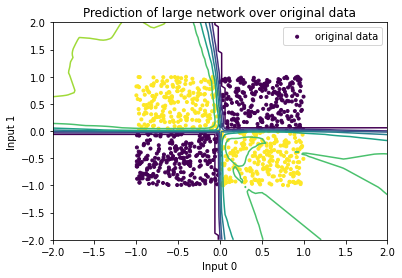

In [11]:
y_pred = model.predict(inputs.T)

X = np.linspace(-2,2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[0], inputs[1], c=outputs[0], marker=".", label="original data")
plt.legend()
plt.title("Prediction of large network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

With 20,601 trainable parameters, we are able to get a pretty good decision boundary at least for the in-sample region (-1,1). However, we can see that the network has not learned the exact XOR rule, as evidenced by some unnecessary level curves at the edges of the decision boundary. One may ask the question, does this network faithfully compute XOR throughout the entire $\mathbb{R}^2$ plane?

## Distill large network into smaller network

In [ ]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=50
num_hidden_layers=3

layers = [ tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu, input_shape=(num_inputs,))]
for i in range(num_hidden_layers-1):
    layers.append( tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu))
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

distilled_model = tf.keras.Sequential(layers)

distilled_model.compile(
# loss='binary_crossentropy', # binary classification
# loss='categorical_crossentropy', # categorical classification (one hot)
loss='mean_squared_error',  # regression
optimizer=tf.keras.optimizers.Adam(0.001),
# optimizer='rmsprop',
# metrics=['accuracy'],
)

distilled_model.fit(
    x=inputs.T,
    y=outputs.T,
    shuffle=True,
    validation_split=.2,
    epochs=100,
    batch_size=128,
    )

distilled_model.summary()